# Introducción: Comparación de Algoritmos sobre Fashion‑MNIST

**Integrantes:**
- Castrejón Bringas, Melanny Angeles
- Coronado Rodriguez, Augusto Takeshi
- Díaz Rodríguez, Carlo Franco
- Ramos Guerra, Ainhoa Jolie 

Este notebook documenta el trabajo práctico de la Unidad 3: comparar el desempeño de redes neuronales frente a algoritmos clásicos de Machine Learning en la clasificación de imágenes del dataset Fashion‑MNIST.

> **Nota:** en este proyecto, implementaremos únicamente el algoritmo clásico Naive Bayes (GaussianNB); las secciones de KNN, SVM y Random Forest quedan omitidas.

Objetivos principales
- Implementar y entrenar Naive Bayes (GaussianNB) y redes neuronales (Dense y CNN).
- Evaluar y comparar métricas (accuracy, precision, recall, F1) y tiempos de entrenamiento/predicción.
- Analizar errores por clase y presentar visualizaciones comparativas.

Dataset
- Fashion‑MNIST: imágenes en escala de grises 28×28, 60.000 muestras de entrenamiento y 10.000 de prueba, 10 clases (Camiseta/Top, Pantalón, Suéter, Vestido, Abrigo, Sandalia, Camisa, Zapatilla, Bolso, Botín).

Estructura del notebook
1. Preparación y exploración de datos: carga, visualización, normalización y aplanado para modelos clásicos (Naive Bayes) y redes neuronales.
2. Modelos clásicos: implementación y evaluación de Naive Bayes (GaussianNB) — baseline y mejoras recomendadas.
3. Redes neuronales: red densa y CNN (arquitecturas sugeridas), curvas de entrenamiento y evaluación final.
4. Análisis comparativo: tabla de métricas, análisis por clase y visualizaciones.
5. Conclusiones y recomendaciones.

Entregables y métricas
- Métricas: Accuracy, Precision (macro/micro), Recall (macro/micro), F1 (macro/micro).
- Entregables: código documentado, gráficas de entrenamiento, matrices de confusión, tabla comparativa de métricas y tiempos, y un breve reporte con conclusiones.

## Paso 0: Instalación e Importación de Librerias

### Instalación de Librerias y Dependencias

In [ ]:
# Instalación de librerias y dependencias
# Usando uv (https://docs.astral.sh/uv/) como gestor de paquetes y versiones de python
!uv add --dev ipykernel uv
!uv add 'tensorflow[and-cuda]' keras pandas numpy seaborn matplotlib scikeras


### Importación y Configuración Inicial

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

print("Librerías importadas exitosamente!")
print(f" Versiones:")
print(f"   • TensorFlow: {tf.__version__}")
print(f"   • Keras: {keras.__version__}")

# Configurar reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

2025-08-25 14:41:24.119410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Librerías importadas exitosamente!
 Versiones:
   • TensorFlow: 2.20.0
   • Keras: 3.11.3


### Definicion de Clase de Datos Para Cada Modelo

In [2]:
from typing import Dict, Any, Optional, Union
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

class ModelData:
    def __init__(
        self,
        model: Optional[BaseEstimator] = None,
        metrics: Optional[Dict[str, float]] = None,
        X_test: Optional[np.ndarray] = None,
        y_test: Optional[np.ndarray] = None
    ):
        """
        Clase para almacenar datos de modelos y métricas, con capacidad de generar visualizaciones bajo demanda.
        
        Args:
            model: Objeto del modelo (NaiveBayes, Dense Network, CNN, etc.)
            metrics: Diccionario de métricas de evaluación
            X_test: Datos de prueba para generar visualizaciones
            y_test: Etiquetas verdaderas para generar visualizaciones
        """
        self.model = model
        self.metrics = metrics or {}
        self.plots: Dict[str, plt.Figure] = {}  # Ahora se generan bajo demanda
        self.X_test = X_test
        self.y_test = y_test

    def generate_confusion_matrix(self) -> plt.Figure:
        """Genera y almacena la matriz de confusión"""
        if self.model is None or self.X_test is None or self.y_test is None:
            raise ValueError("Modelo o datos de prueba no disponibles")
            
        y_pred = self.model.predict(self.X_test)
        fig, ax = plt.subplots(figsize=(10, 8))
        ConfusionMatrixDisplay.from_predictions(
            self.y_test, 
            y_pred,
            ax=ax,
            cmap='Blues',
            colorbar=False
        )
        ax.set_title('Matriz de Confusión')
        self.plots['confusion_matrix'] = fig
        return fig

    def generate_class_report(self) -> plt.Figure:
        """Genera y almacena un reporte por clase"""
        if self.metrics.get('class_report') is None:
            raise ValueError("Reporte por clase no disponible en las métricas")
            
        # Implementación de la visualización del reporte por clase
        fig = plt.figure(figsize=(10, 6))
        # ... código para generar el gráfico ...
        self.plots['class_report'] = fig
        return fig

    def generate_all_plots(self) -> None:
        """Genera todos los plots disponibles automáticamente"""
        try:
            self.generate_confusion_matrix()
        except Exception as e:
            print(f"No se pudo generar matriz de confusión: {e}")
            
        try:
            self.generate_class_report()
        except Exception as e:
            print(f"No se pudo generar reporte por clase: {e}")

# Array vacío para almacenar objetos ModelData
model_results: list[ModelData] = []

## Paso 1: Preparación y Exploración de Datos

Actividades principales:

1. Carga y exploración inicial
   - Cargar el dataset Fashion‑MNIST desde `keras.datasets.fashion_mnist`.
   - Mostrar tamaño de los conjuntos de entrenamiento y prueba.
   - Visualizar muestras representativas de cada una de las 10 clases.
   - Analizar la distribución de clases y detectar desequilibrios.

2. Preprocesamiento
   - Normalizar los píxeles a rango [0, 1].
   - Aplanar imágenes a vectores de 784 dimensiones para los modelos clásicos.
   - Preparar one‑hot encodings y partición train/validation para redes neuronales.

Entregables:
- Gráficos de muestras por clase.
- Estadísticas básicas (shape, distribución de clases).
- Código claramente documentado para el preprocesamiento.

### Carga y Exploración de Datos

Cargando dataset Fashion MNIST...
Dataset cargado exitosamente!
Información del dataset:
------------------------
   • Datos de entrenamiento: (60000, 28, 28)
   • Etiquetas de entrenamiento: (60000,)
   • Datos de prueba: (10000, 28, 28)
   • Etiquetas de prueba: (10000,)
Propiedades básicas:
--------------------
   • Tipo de datos: uint8
   • Rango de valores: 0 - 255
   • Forma de una imagen: (28, 28)
   • Clases únicas: [0 1 2 3 4 5 6 7 8 9]

 Distribución de clases en entrenamiento:
     Prenda 0: 6,000 ejemplos
     Prenda 1: 6,000 ejemplos
     Prenda 2: 6,000 ejemplos
     Prenda 3: 6,000 ejemplos
     Prenda 4: 6,000 ejemplos
     Prenda 5: 6,000 ejemplos
     Prenda 6: 6,000 ejemplos
     Prenda 7: 6,000 ejemplos
     Prenda 8: 6,000 ejemplos
     Prenda 9: 6,000 ejemplos


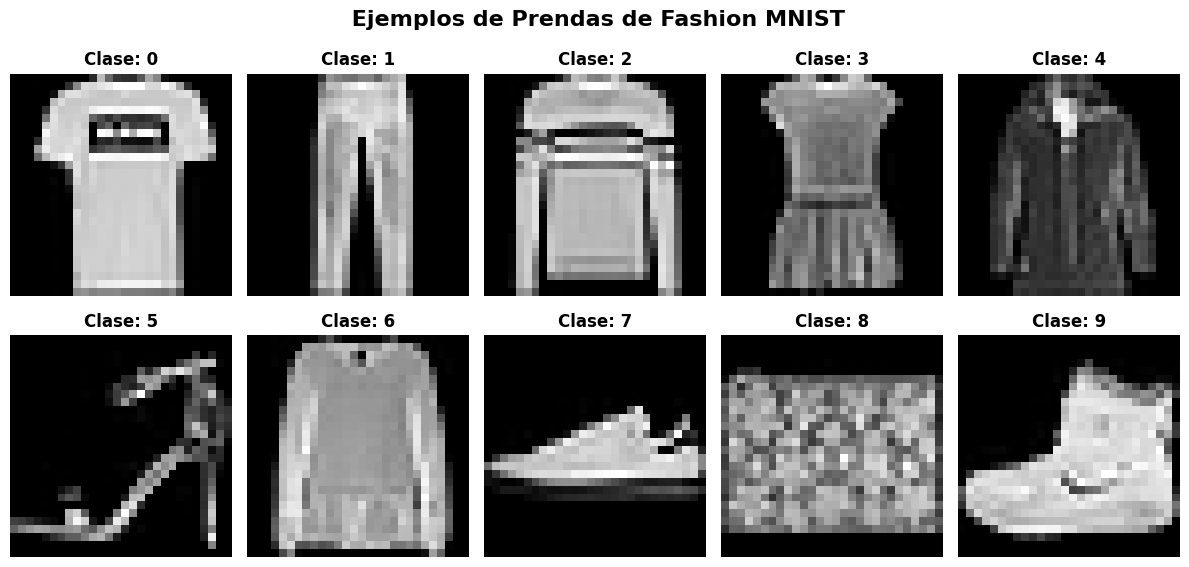

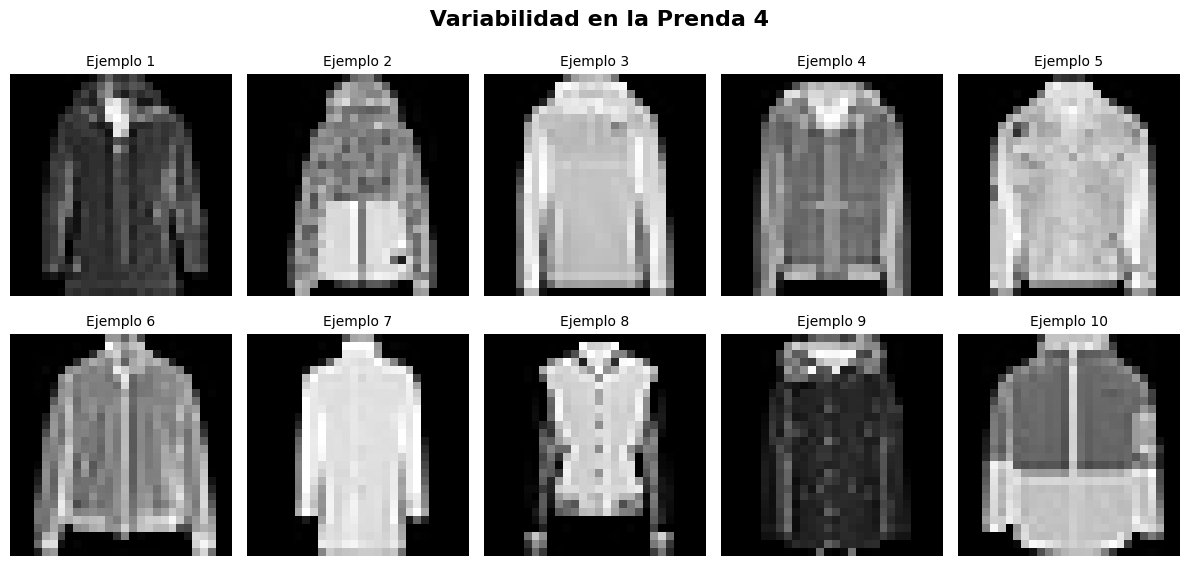

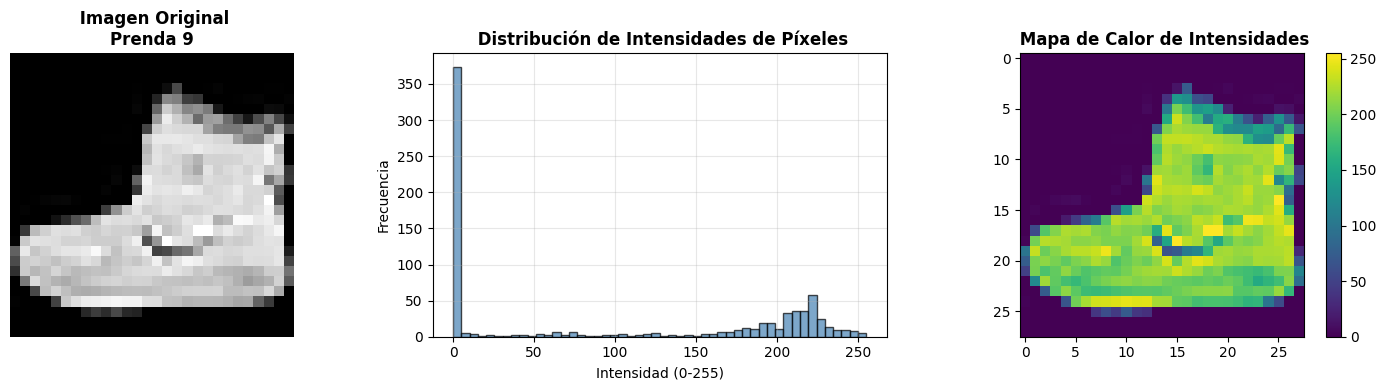

 Estadísticas de la Imagen de la Prenda 9:
   • Media: 97.25
   • Desviación estándar: 101.79
   • Píxeles no-cero: 433 de 784
   • Porcentaje de píxeles activos: 55.2%


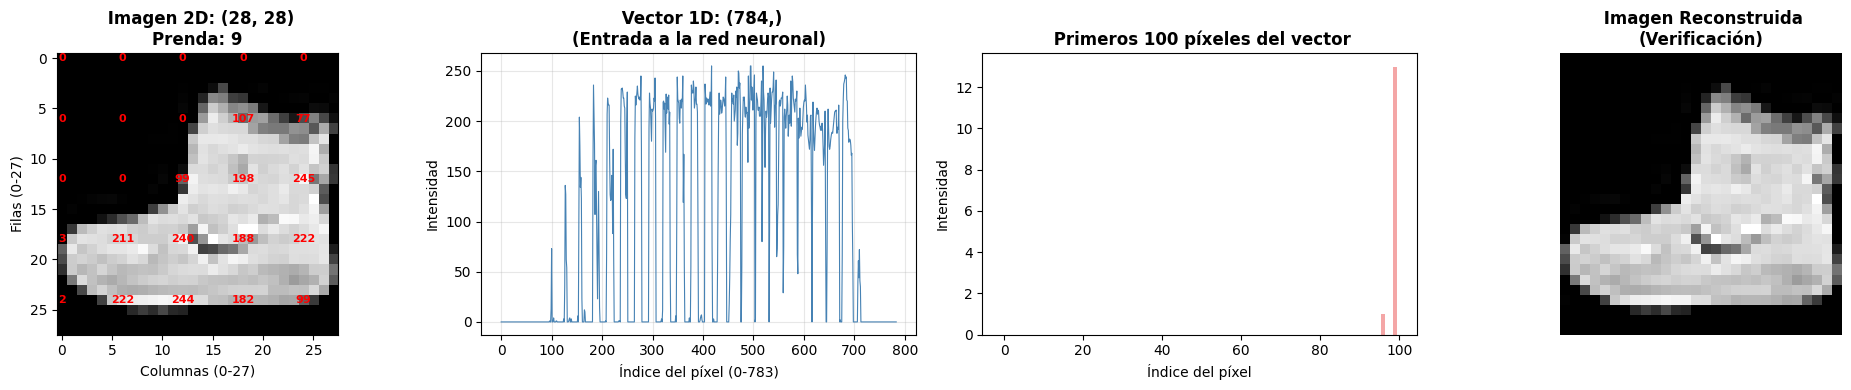

 ANÁLISIS DEL PROCESO:
   1. Imagen original: matriz de (28, 28)
   2. Aplanada: vector de (784,)
   3. Cada píxel representa la intensidad en esa posición
   4. La red neuronal verá estos 784 números como entrada
   5. Debe aprender a reconocer patrones en estos 784 valores


In [3]:
# Paso 1 — Preparación y Exploración de Datos (bloque ejecutable limpio)
# Carga, visualización, normalización, aplanado y partición train/validation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Cargar datos MNIST
print("Cargando dataset Fashion MNIST...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Dataset cargado exitosamente!")
print("========================================")
print(f"Información del dataset:")
print("------------------------")
print(f"   • Datos de entrenamiento: {X_train.shape}")
print(f"   • Etiquetas de entrenamiento: {y_train.shape}")
print(f"   • Datos de prueba: {X_test.shape}")
print(f"   • Etiquetas de prueba: {y_test.shape}")

# Explorar propiedades básicas del dataset
print("========================================")
print(f"Propiedades básicas:")
print("--------------------")
print(f"   • Tipo de datos: {X_train.dtype}")
print(f"   • Rango de valores: {X_train.min()} - {X_train.max()}")
print(f"   • Forma de una imagen: {X_train[0].shape}")
print(f"   • Clases únicas: {np.unique(y_train)}")

# Contar ejemplos por clase
unique, counts = np.unique(y_train, return_counts=True)
print(f"\n Distribución de clases en entrenamiento:")
for clothing, count in zip(unique, counts):
    print(f"     Prenda {clothing}: {count:,} ejemplos")

###  Visualización de Ejemplos por Prenda

# Visualizar ejemplos de cada dígito (0-9)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(' Ejemplos de Prendas de Fashion MNIST', fontsize=16, fontweight='bold')

for clothing in range(10):
    # Encontrar el primer ejemplo de cada clase
    idx = np.where(y_train == clothing)[0][0]
    row, col = clothing // 5, clothing % 5

    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Clase: {clothing}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Variabilidad Intra-Clase

# Mostrar múltiples ejemplos del mismo dígito para ver variabilidad
cloth_to_analyze = 4  # Cambiar por cualquier dígito 0-9
indices = np.where(y_train == cloth_to_analyze)[0][:10]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(f' Variabilidad en la Prenda {cloth_to_analyze}', fontsize=16, fontweight='bold')

for i, idx in enumerate(indices):
    row, col = i // 5, i % 5
    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Ejemplo {i+1}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

###  Análisis de Intensidad de Píxeles

# Analizar la distribución de intensidades de píxeles
sample_image = X_train[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Imagen original
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f' Imagen Original\nPrenda {y_train[0]}', fontweight='bold')
axes[0].axis('off')

# Histograma de intensidades
axes[1].hist(sample_image.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_title(' Distribución de Intensidades de Píxeles', fontweight='bold')
axes[1].set_xlabel('Intensidad (0-255)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)

# Mapa de calor 3D de la imagen
im = axes[2].imshow(sample_image, cmap='viridis')
axes[2].set_title(' Mapa de Calor de Intensidades', fontweight='bold')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

# Mostrar estadísticas de la imagen
print(f" Estadísticas de la Imagen de la Prenda {y_train[0]}:")
print(f"   • Media: {sample_image.mean():.2f}")
print(f"   • Desviación estándar: {sample_image.std():.2f}")
print(f"   • Píxeles no-cero: {np.count_nonzero(sample_image):,} de {sample_image.size:,}")
print(f"   • Porcentaje de píxeles activos: {np.count_nonzero(sample_image)/sample_image.size*100:.1f}%")

### Visualización de la Transformación 2D → 1D

# Mostrar cómo se convierte una imagen 2D en vector 1D
sample_idx = 0
sample_image = X_train[sample_idx]
sample_label = y_train[sample_idx]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Imagen original 28x28
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f' Imagen 2D: {sample_image.shape}\nPrenda: {sample_label}', fontweight='bold')
axes[0].set_xlabel('Columnas (0-27)')
axes[0].set_ylabel('Filas (0-27)')

# Mostrar algunos valores de píxeles
for i in range(0, 28, 6):
    for j in range(0, 28, 6):
        axes[0].text(j, i, f'{sample_image[i,j]:.0f}',
                    ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Vector 1D
flattened = sample_image.flatten()
axes[1].plot(flattened, linewidth=0.8, color='steelblue')
axes[1].set_title(f' Vector 1D: {flattened.shape}\n(Entrada a la red neuronal)', fontweight='bold')
axes[1].set_xlabel('Índice del píxel (0-783)')
axes[1].set_ylabel('Intensidad')
axes[1].grid(True, alpha=0.3)

# Mostrar las primeras 100 componentes del vector
axes[2].bar(range(100), flattened[:100], width=1.0, color='lightcoral', alpha=0.7)
axes[2].set_title(' Primeros 100 píxeles del vector', fontweight='bold')
axes[2].set_xlabel('Índice del píxel')
axes[2].set_ylabel('Intensidad')

# Reconstruir la imagen desde el vector para verificar
reconstructed = flattened.reshape(28, 28)
axes[3].imshow(reconstructed, cmap='gray')
axes[3].set_title(' Imagen Reconstruida\n(Verificación)', fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(" ANÁLISIS DEL PROCESO:")
print(f"   1. Imagen original: matriz de {sample_image.shape}")
print(f"   2. Aplanada: vector de {flattened.shape}")
print(f"   3. Cada píxel representa la intensidad en esa posición")
print(f"   4. La red neuronal verá estos {len(flattened)} números como entrada")
print(f"   5. Debe aprender a reconocer patrones en estos {len(flattened)} valores")


### Preprocesamiento de Datos

 PREPROCESAMIENTO DE DATOS:
   Antes de normalizar - Rango: [0, 255]
   Después de normalizar - Rango: [0.000, 1.000]


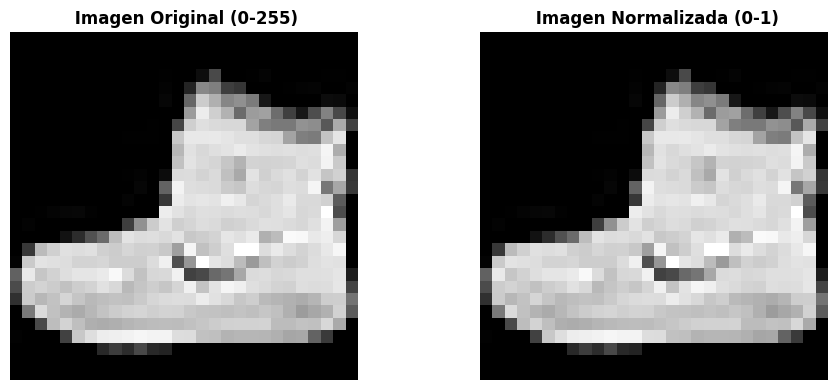


 TRANSFORMACIÓN DE FORMA:
   X_train original: (60000, 28, 28)
   X_train_flat: (60000, 784)
   Cada imagen 28×28 = 784 píxeles se convierte en vector de 784 elementos

  CODIFICACIÓN ONE-HOT:
   y_train original shape: (60000,)
   y_train_onehot shape: (60000, 10)

   Ejemplos de codificación one-hot:
     Prenda 9 → [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     Prenda 3 → [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


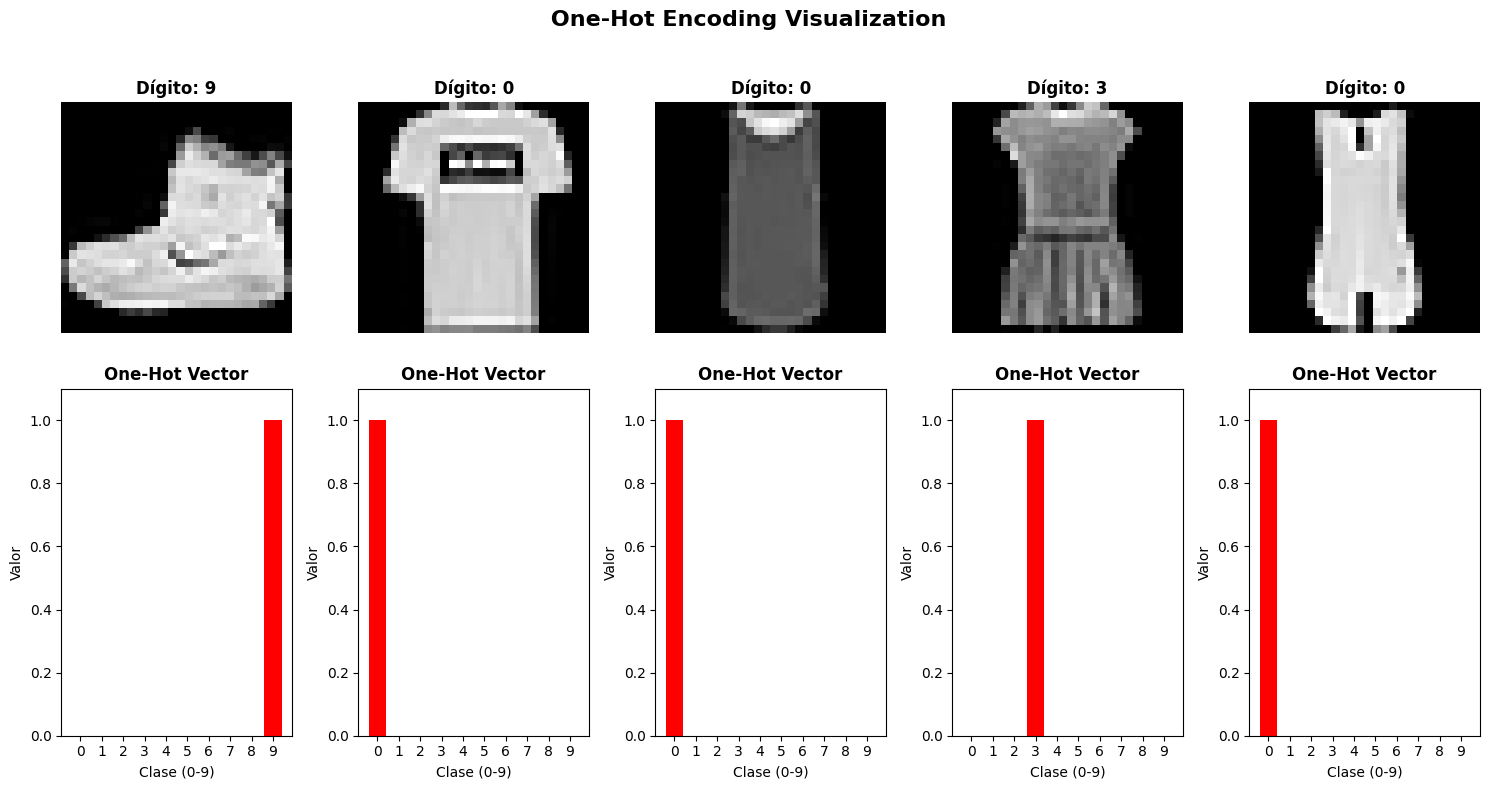

In [4]:
# Normalizar píxeles a rango [0,1]
print(" PREPROCESAMIENTO DE DATOS:")
print(f"   Antes de normalizar - Rango: [{X_train.min()}, {X_train.max()}]")

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"   Después de normalizar - Rango: [{X_train.min():.3f}, {X_train.max():.3f}]")

# Visualizar el efecto de la normalización
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Imagen sin normalizar (recreada para visualización)
original_image = (X_train[0] * 255).astype('uint8')
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title(' Imagen Original (0-255)', fontweight='bold')
axes[0].axis('off')

# Imagen normalizada
axes[1].imshow(X_train[0], cmap='gray')
axes[1].set_title(' Imagen Normalizada (0-1)', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Aplanar imágenes de 28x28 a vector 784x1
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # (10000, 784)

print(f"\n TRANSFORMACIÓN DE FORMA:")
print(f"   X_train original: {X_train.shape}")
print(f"   X_train_flat: {X_train_flat.shape}")
print(f"   Cada imagen 28×28 = {28*28} píxeles se convierte en vector de 784 elementos")

# Convertir etiquetas a codificación one-hot
y_train_onehot = np.eye(10)[y_train]  # (60000, 10)
y_test_onehot = np.eye(10)[y_test]    # (10000, 10)

print(f"\n  CODIFICACIÓN ONE-HOT:")
print(f"   y_train original shape: {y_train.shape}")
print(f"   y_train_onehot shape: {y_train_onehot.shape}")

# Mostrar ejemplos de one-hot encoding
print("\n   Ejemplos de codificación one-hot:")
for i in range(5):
    print(f"     Prenda {y_train[i]} → {y_train_onehot[i]}")

###  Visualización One-Hot Encoding

# Visualizar el concepto de one-hot
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle(' One-Hot Encoding Visualization', fontsize=16, fontweight='bold')

for i in range(5):
    # Mostrar imagen
    axes[0, i].imshow(X_train[i], cmap='gray')
    axes[0, i].set_title(f'Dígito: {y_train[i]}', fontweight='bold')
    axes[0, i].axis('off')

    # Mostrar codificación one-hot como barras
    bars = axes[1, i].bar(range(10), y_train_onehot[i],
                         color=['red' if j == y_train[i] else 'lightblue' for j in range(10)])
    axes[1, i].set_title('One-Hot Vector', fontweight='bold')
    axes[1, i].set_xlabel('Clase (0-9)')
    axes[1, i].set_ylabel('Valor')
    axes[1, i].set_ylim(0, 1.1)
    axes[1, i].set_xticks(range(10))

plt.tight_layout()
plt.show()

## Parte 2: Algoritmos Clásicos

Implementación específica para este grupo:

- Naive Bayes (GaussianNB) — Implementar y evaluar como baseline.
  - Entrenar con los vectores aplanados.
  - Explorar preprocesados recomendados: escalado (StandardScaler/MinMax), PCA (50–200 componentes) y búsquedas de `var_smoothing`.
  - Evaluar tiempos de entrenamiento y predicción.
  - Generar matriz de confusión y reporte de clasificación.

Se omiten las implementaciones directas de KNN, SVM y Random Forest por alcance de grupo; se pueden mantener notas y celdas comentadas para referencia.

Entregables para esta parte:
- Código entrenando GaussianNB sobre los datos aplanados.
- Matriz de confusión y métricas (accuracy, precision, recall, F1‑score).
- Análisis de preprocesamiento y tiempos.

### Mejoras recomendadas — GaussianNB (baseline)

- Preprocesado: escalar/normalizar las features (StandardScaler o MinMax); eliminar ruido y outliers.
- Reducir dimensionalidad con PCA/TruncatedSVD (50–200 componentes) para quitar redundancia.
- Selección de features (VarianceThreshold, SelectKBest) si hay muchas columnas.
- Ajustes de modelo: explorar `var_smoothing` en log-space (1e-12 → 1e-3) y `fit_prior`/`class_prior`.
- Pipeline: usar Pipeline(Scaler, PCA, GaussianNB) y Grid/RandomSearch con validación estratificada.
- Alternativa: si los features no son gaussianos, probar MultinomialNB/BernoulliNB tras transformar.


In [ ]:
# Importaciones adicionales necesarias
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Definir transformador de identidad para opción sin escalado
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X

# Pipeline para Naive Bayes
nb_pipeline = Pipeline([
    ('scaler', IdentityTransformer()),  # Por defecto sin escalado
    ('nb', GaussianNB())
])

# Parámetros para GridSearch
param_grid = {
    'scaler': [StandardScaler(), IdentityTransformer()],  # Probar con y sin escalado
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Valores para suavizado
}

# GridSearch
grid_search = GridSearchCV(
    nb_pipeline, 
    param_grid, 
    cv=3,  # 3-fold CV para eficiencia
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
print("Entrenando Naive Bayes con GridSearch...")
grid_search.fit(X_train_flat, y_train)

# Mejor modelo
best_nb_model = grid_search.best_estimator_

# Predecir
y_pred = best_nb_model.predict(X_test_flat)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred, output_dict=True)

# Crear ModelData
nb_model_data = ModelData(
    model=best_nb_model,
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'class_report': class_report
    },
    X_test=X_test_flat,
    y_test=y_test
)

# Generar matriz de confusión
try:
    nb_model_data.generate_confusion_matrix()
except Exception as e:
    print(f"Error generando matriz de confusión: {e}")

# Añadir a resultados
model_results.append(nb_model_data)

# Imprimir resultados
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_:.4f}")
print(f"Precisión en prueba: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# No mostrar la matriz de confusión nuevamente para evitar duplicación
# La matriz ya se mostró en generate_confusion_matrix()

## Parte 3: Redes Neuronales

3.1 Red Neuronal Simple (Dense) — 10 pts
- Arquitectura sugerida:
  - Input: 784 neuronas (imágenes aplanadas)
  - Dense 128 + ReLU
  - Dense 64 + ReLU
  - Dense 10 + Softmax
- Usar `categorical_crossentropy` y métricas de accuracy.

3.2 Red Convolucional (CNN) — 20 pts
- Arquitectura sugerida:
  - Conv2D(32, 3x3) + ReLU + MaxPooling
  - Conv2D(64, 3x3) + ReLU + MaxPooling
  - Flatten
  - Dense(128) + ReLU + Dropout(0.5)
  - Dense(10) + Softmax
- Aplicar data augmentation como bonus opcional.

Entregables:
- Implementación de ambas redes.
- Gráficas de loss y accuracy durante entrenamiento.
- Evaluación en el conjunto de prueba y análisis de overfitting/underfitting.

CONFIGURACIÓN AVANZADA PARA WSL2 Y GPU
GPU física detectada: 1
GPU lógica disponible: 1
Crecimiento de memoria de GPU habilitado

CARGANDO Y PREPROCESANDO DATASET FASHION-MNIST


I0000 00:00:1756154893.232012  237601 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Forma original de X_train: (60000, 28, 28)
Forma original de X_test: (10000, 28, 28)

PREPROCESAMIENTO DE DATOS:
   Antes de normalizar - Rango: [0, 255]
   Después de normalizar - Rango: [0.000, 1.000]

 TRANSFORMACIÓN DE FORMA:
   X_train original: (60000, 28, 28)
   X_train_flat: (60000, 784)

DIVISIÓN DE DATOS:
   Entrenamiento: 48000 imágenes (80% de 60,000)
   Validación: 12000 imágenes (20% de 60,000)
   Prueba: 10000 imágenes (conjunto original de prueba)

Clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Número de combinaciones de hiperparámetros: 4
Número total de entrenamientos (con 2-fold CV): 8

INICIANDO GRIDSEARCH OPTIMIZADO PARA RED DENSA
Fitting 2 folds for each of 4 candidates, totalling 8 fits


I0000 00:00:1756154900.673412  237669 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Tiempo total de GridSearch: 3.03 minutos

Mejores parámetros encontrados: {'batch_size': 256, 'epochs': 25, 'model__dropout_rate': 0.5, 'model__hidden_units_1': 512, 'model__hidden_units_2': 256, 'model__hidden_units_3': 128, 'model__learning_rate': 0.0005}

ENTRENAMIENTO FINAL CON MEJORES PARÁMETROS
Entrenando modelo final...
Epoch 1/25


/home/dom1nux/Repos/University/si_proyecto_u3/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6717 - loss: 0.9913 - val_accuracy: 0.7847 - val_loss: 0.6252 - learning_rate: 5.0000e-04
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7884 - loss: 0.6055 - val_accuracy: 0.8480 - val_loss: 0.4234 - learning_rate: 5.0000e-04
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8145 - loss: 0.5268 - val_accuracy: 0.8578 - val_loss: 0.3880 - learning_rate: 5.0000e-04
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8320 - loss: 0.4775 - val_accuracy: 0.8645 - val_loss: 0.3743 - learning_rate: 5.0000e-04
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8403 - loss: 0.4523 - val_accuracy: 0.8696 - val_loss: 0.3663 - learning_rate: 5.0000e-04
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8458 - loss: 0.4330 - val_accuracy: 0.8742 - val_loss: 0.3477 - learning_rate: 5.0000e-04
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8519 - 

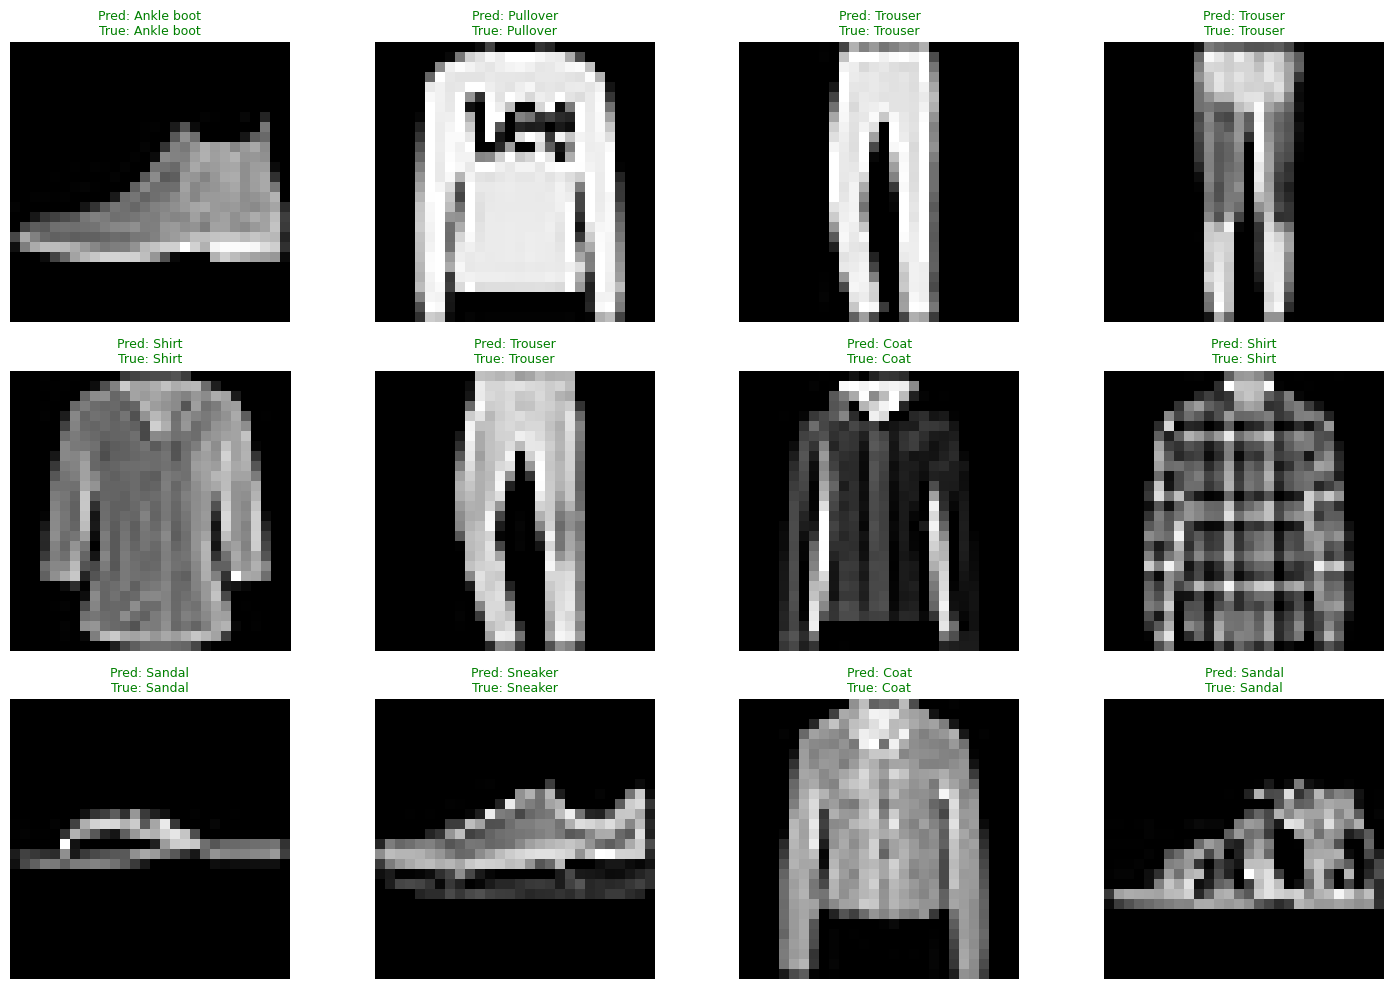


Modelo guardado como 'fashion_mnist_dense_model.h5'

INFORMACIÓN FINAL DEL ENTRENAMIENTO
Épocas de entrenamiento: 25
Precisión final en validación: 0.8950
Pérdida final en validación: 0.3023
Tamaño del conjunto de entrenamiento: 48000 imágenes
Tamaño del conjunto de validación: 12000 imágenes
Tamaño del conjunto de prueba: 10000 imágenes


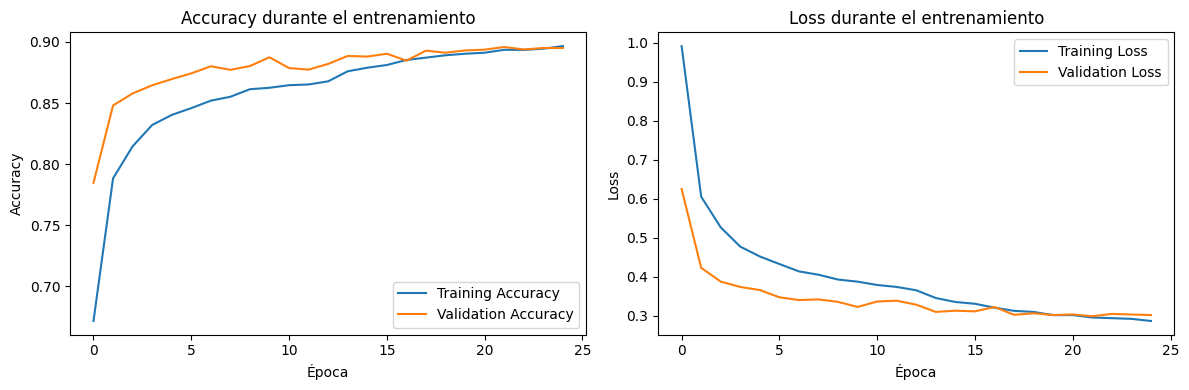

In [1]:
# Importaciones optimizadas para máximo rendimiento
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'
os.environ['TF_ENABLE_CUDNN_TENSOR_OP_MATH'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '0'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reducir logs de TensorFlow

# Importar TensorFlow después de configurar las variables de entorno
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.mixed_precision import set_global_policy
from keras.datasets import fashion_mnist
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import time

# Configuración de política de precisión mixta
set_global_policy('mixed_float16')

# Verificar y configurar GPU para WSL2
print("=" * 60)
print("CONFIGURACIÓN AVANZADA PARA WSL2 Y GPU")
print("=" * 60)

# Configuración de GPU optimizada para WSL2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configuración simplificada - solo growth memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"GPU física detectada: {len(gpus)}")
        print(f"GPU lógica disponible: {len(logical_gpus)}")
        print("Crecimiento de memoria de GPU habilitado")
        
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")
else:
    print("No se detectó GPU, usando CPU")

# CARGAR Y PREPROCESAR DATOS FASHION-MNIST
print("\n" + "=" * 60)
print("CARGANDO Y PREPROCESANDO DATASET FASHION-MNIST")
print("=" * 60)

# Cargar dataset Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(f"Forma original de X_train: {X_train_full.shape}")
print(f"Forma original de X_test: {X_test.shape}")

# Aplicar el preprocesamiento
print("\nPREPROCESAMIENTO DE DATOS:")
print(f"   Antes de normalizar - Rango: [{X_train_full.min()}, {X_train_full.max()}]")

# Normalizar píxeles a rango [0,1]
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"   Después de normalizar - Rango: [{X_train_full.min():.3f}, {X_train_full.max():.3f}]")

# Aplanar imágenes de 28x28 a vector 784x1
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1)  # (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # (10000, 784)

print(f"\n TRANSFORMACIÓN DE FORMA:")
print(f"   X_train original: {X_train_full.shape}")
print(f"   X_train_flat: {X_train_flat.shape}")

# DIVIDIR LOS DATOS (80% entrenamiento, 20% validación)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_flat, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nDIVISIÓN DE DATOS:")
print(f"   Entrenamiento: {X_train_split.shape[0]} imágenes (80% de 60,000)")
print(f"   Validación: {X_val_split.shape[0]} imágenes (20% de 60,000)")
print(f"   Prueba: {X_test_flat.shape[0]} imágenes (conjunto original de prueba)")

# Clases de Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"\nClases: {class_names}")

# Optimización: Precache de datos para GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_dataset = train_dataset.shuffle(5000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(256)  # Batch size más grande para redes densas
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

# Crear dataset de validación
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset = val_dataset.batch(256)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Función para crear el modelo de red neuronal densa optimizada
def create_dense_model(
    meta,
    learning_rate=0.001,
    dropout_rate=0.5,
    hidden_units_1=512,
    hidden_units_2=256,
    hidden_units_3=128,
    **kwargs
):
    input_shape = meta["X_shape_"][1:]  # Obtener forma de entrada
    
    model = Sequential([
        Input(shape=input_shape),
        Dense(hidden_units_1, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(hidden_units_2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(hidden_units_3, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(meta["n_classes_"], activation='softmax', dtype='float32')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear el wrapper de Keras para scikit-learn
dense_model = KerasClassifier(
    model=create_dense_model,
    learning_rate=0.001,
    dropout_rate=0.5,
    hidden_units_1=512,
    hidden_units_2=256,
    hidden_units_3=128,
    verbose=0,
    target_type="multiclass"
)

# GRID SEARCH OPTIMIZADO (solo 4 combinaciones para máxima velocidad)
param_grid = {
    'model__learning_rate': [0.001, 0.0005],
    'model__dropout_rate': [0.3, 0.5],
    'model__hidden_units_1': [512],
    'model__hidden_units_2': [256],
    'model__hidden_units_3': [128],
    'epochs': [25],  # Reducido a 15 épocas para mayor velocidad
    'batch_size': [256]
}

print(f"\nNúmero de combinaciones de hiperparámetros: {np.prod([len(v) for v in param_grid.values()])}")
print(f"Número total de entrenamientos (con 2-fold CV): {np.prod([len(v) for v in param_grid.values()]) * 2}")

# Realizar GridSearch optimizado
print("\n" + "=" * 60)
print("INICIANDO GRIDSEARCH OPTIMIZADO PARA RED DENSA")
print("=" * 60)

# Medir tiempo de ejecución
start_time = time.time()

grid_search_dense = GridSearchCV(
    estimator=dense_model,
    param_grid=param_grid,
    cv=2,
    scoring='accuracy',
    verbose=1,
    n_jobs=1,  # Importante: no usar n_jobs > 1 con Keras
    error_score='raise'
)

# Usar solo datos de entrenamiento para grid search
grid_search_dense.fit(X_train_split, y_train_split)

end_time = time.time()
print(f"\nTiempo total de GridSearch: {(end_time - start_time) / 60:.2f} minutos")

# Obtener los mejores parámetros
best_params = grid_search_dense.best_params_
print(f"\nMejores parámetros encontrados: {best_params}")

# Entrenamiento final con los mejores parámetros
print("\n" + "=" * 60)
print("ENTRENAMIENTO FINAL CON MEJORES PARÁMETROS")
print("=" * 60)

# Extraer parámetros para el modelo final
model_params = {}
fit_params = {}
for key, value in best_params.items():
    if key.startswith('model__'):
        model_params[key[7:]] = value
    else:
        fit_params[key] = value

# Crear modelo final optimizado
final_dense_model = Sequential([
    Dense(model_params.get('hidden_units_1', 512), activation='relu', input_shape=(784,)),
    BatchNormalization(),
    Dropout(model_params.get('dropout_rate', 0.5)),
    Dense(model_params.get('hidden_units_2', 256), activation='relu'),
    BatchNormalization(),
    Dropout(model_params.get('dropout_rate', 0.5)),
    Dense(model_params.get('hidden_units_3', 128), activation='relu'),
    BatchNormalization(),
    Dropout(model_params.get('dropout_rate', 0.5)),
    Dense(len(np.unique(y_train_split)), activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=model_params.get('learning_rate', 0.001))
final_dense_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks para entrenamiento eficiente
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reducido para mayor velocidad
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Entrenamiento final con datasets optimizados
print("Entrenando modelo final...")
final_history = final_dense_model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    epochs=fit_params.get('epochs', 30),
    verbose=1
)

# Evaluación FINAL con datos de TEST
print("\nEvaluando modelo final con datos de TEST...")
y_pred_proba = final_dense_model.predict(X_test_flat, batch_size=256, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "=" * 60)
print("RESULTADOS FINALES EN DATOS DE TEST (10,000 imágenes)")
print("=" * 60)
print(f"Precisión: {accuracy:.4f}")
print(f"Precisión ponderada: {precision:.4f}")
print(f"Recall ponderado: {recall:.4f}")
print(f"F1-Score ponderado: {f1:.4f}")

# Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Visualizar algunas predicciones
print("\nVisualizando algunas predicciones...")
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[i], cmap='gray')
    pred_label = class_names[y_pred[i]]
    true_label = class_names[y_test[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Guardar modelo para uso futuro
final_dense_model.save('fashion_mnist_dense_model.h5')
print("\nModelo guardado como 'fashion_mnist_dense_model.h5'")

# Mostrar información final de entrenamiento
print("\n" + "=" * 60)
print("INFORMACIÓN FINAL DEL ENTRENAMIENTO")
print("=" * 60)
print(f"Épocas de entrenamiento: {len(final_history.history['loss'])}")
print(f"Precisión final en validación: {final_history.history['val_accuracy'][-1]:.4f}")
print(f"Pérdida final en validación: {final_history.history['val_loss'][-1]:.4f}")
print(f"Tamaño del conjunto de entrenamiento: {X_train_split.shape[0]} imágenes")
print(f"Tamaño del conjunto de validación: {X_val_split.shape[0]} imágenes")
print(f"Tamaño del conjunto de prueba: {X_test_flat.shape[0]} imágenes")

# Visualizar el historial de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

CONFIGURACIÓN AVANZADA PARA WSL2 Y GPU


I0000 00:00:1756152791.063217  222940 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


GPU física detectada: 1
GPU lógica disponible: 1
Crecimiento de memoria de GPU habilitado

CARGANDO Y PREPROCESANDO DATASET FASHION-MNIST
Forma original de X_train: (60000, 28, 28)
Forma original de X_test: (10000, 28, 28)

PREPROCESAMIENTO DE DATOS:
   Antes de normalizar - Rango: [0, 255]
   Después de normalizar - Rango: [0.000, 1.000]

 TRANSFORMACIÓN DE FORMA:
   X_train original: (60000, 28, 28)
   X_train_flat: (60000, 784)

DIVISIÓN DE DATOS:
   Entrenamiento: 48000 imágenes (80% de 60,000)
   Validación: 12000 imágenes (20% de 60,000)
   Prueba: 10000 imágenes (conjunto original de prueba)

PREPARACIÓN PARA CNN:
   X_train_cnn: (48000, 28, 28, 1)
   X_val_cnn: (12000, 28, 28, 1)
   X_test_cnn: (10000, 28, 28, 1)

Clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Número de combinaciones de hiperparámetros: 4
Número total de entrenamientos (con 2-fold CV): 8

INICIANDO GRIDSEARCH OPTIMIZADO
Fitting 2 folds for eac

I0000 00:00:1756152832.871274  223960 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Tiempo total de GridSearch: 9.98 minutos

Mejores parámetros encontrados: {'batch_size': 64, 'epochs': 15, 'model__dropout_rate': 0.5, 'model__filters_layer1': 64, 'model__learning_rate': 0.001}

ENTRENAMIENTO FINAL CON MEJORES PARÁMETROS
Entrenando modelo final...
Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8244 - loss: 0.5068 - val_accuracy: 0.6326 - val_loss: 1.1030 - learning_rate: 0.0010
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8884 - loss: 0.3131 - val_accuracy: 0.9007 - val_loss: 0.2726 - learning_rate: 0.0010
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9045 - loss: 0.2666 - val_accuracy: 0.9002 - val_loss: 0.2829 - learning_rate: 0.0010
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9177 - loss: 0.2305 - val_accuracy: 0.9111 - val_loss: 0.2396 - learning_rate: 0.0010
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9254 - loss: 0.2084 - val_accuracy: 0.9123 - val_loss: 0.

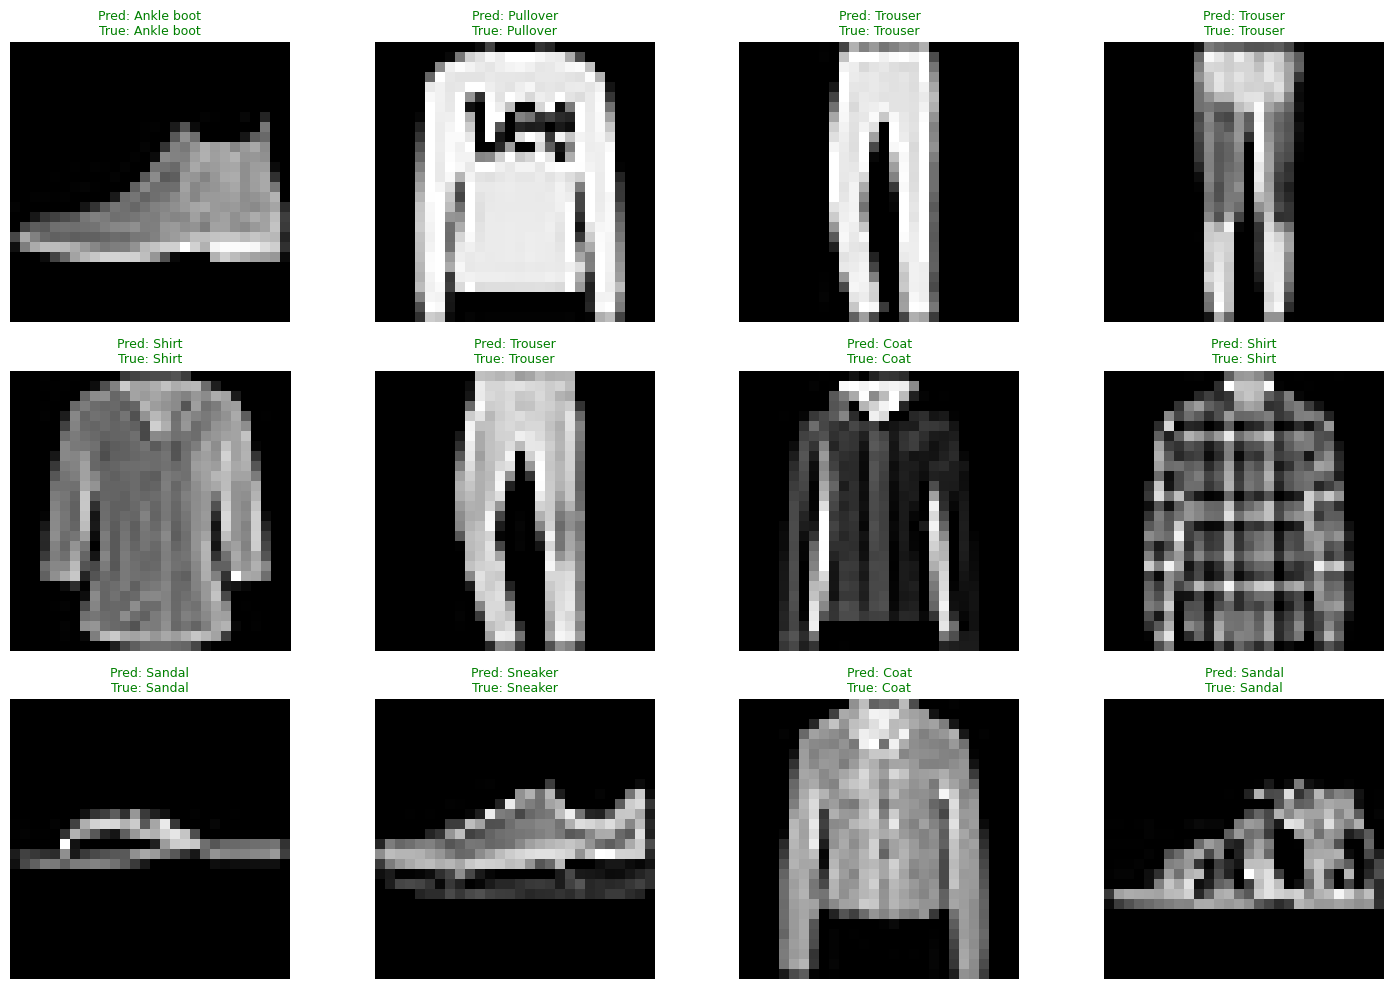


Modelo guardado como 'fashion_mnist_cnn_model.h5'

INFORMACIÓN FINAL DEL ENTRENAMIENTO
Épocas de entrenamiento: 9
Precisión final en validación: 0.9129
Pérdida final en validación: 0.2507
Tamaño del conjunto de entrenamiento: 48000 imágenes
Tamaño del conjunto de validación: 12000 imágenes
Tamaño del conjunto de prueba: 10000 imágenes


In [ ]:
# Importaciones optimizadas para máximo rendimiento
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'
os.environ['TF_ENABLE_CUDNN_TENSOR_OP_MATH'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '0'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reducir logs de TensorFlow

# Importar TensorFlow después de configurar las variables de entorno
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.mixed_precision import set_global_policy
from keras.datasets import fashion_mnist
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Configuración de política de precisión mixta
set_global_policy('mixed_float16')

# Verificar y configurar GPU para WSL2
print("=" * 60)
print("CONFIGURACIÓN AVANZADA PARA WSL2 Y GPU")
print("=" * 60)

# Configuración de GPU optimizada para WSL2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configuración simplificada - solo growth memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"GPU física detectada: {len(gpus)}")
        print(f"GPU lógica disponible: {len(logical_gpus)}")
        print("Crecimiento de memoria de GPU habilitado")
        
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")
else:
    print("No se detectó GPU, usando CPU")

# CARGAR Y PREPROCESAR DATOS FASHION-MNIST
print("\n" + "=" * 60)
print("CARGANDO Y PREPROCESANDO DATASET FASHION-MNIST")
print("=" * 60)

# Cargar dataset Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(f"Forma original de X_train: {X_train_full.shape}")
print(f"Forma original de X_test: {X_test.shape}")

# Aplicar el preprocesamiento
print("\nPREPROCESAMIENTO DE DATOS:")
print(f"   Antes de normalizar - Rango: [{X_train_full.min()}, {X_train_full.max()}]")

# Normalizar píxeles a rango [0,1]
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"   Después de normalizar - Rango: [{X_train_full.min():.3f}, {X_train_full.max():.3f}]")

# Aplanar imágenes de 28x28 a vector 784x1
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1)  # (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # (10000, 784)

print(f"\n TRANSFORMACIÓN DE FORMA:")
print(f"   X_train original: {X_train_full.shape}")
print(f"   X_train_flat: {X_train_flat.shape}")

# DIVIDIR LOS DATOS COMO EN TU PREPROCESAMIENTO (80% entrenamiento, 20% validación)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_flat, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nDIVISIÓN DE DATOS:")
print(f"   Entrenamiento: {X_train_split.shape[0]} imágenes (80% de 60,000)")
print(f"   Validación: {X_val_split.shape[0]} imágenes (20% de 60,000)")
print(f"   Prueba: {X_test_flat.shape[0]} imágenes (conjunto original de prueba)")

# Para la CNN, necesitamos remodelar los datos a su forma original (28x28x1)
X_train_cnn = X_train_split.reshape(-1, 28, 28, 1)
X_val_cnn = X_val_split.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_flat.reshape(-1, 28, 28, 1)

print(f"\nPREPARACIÓN PARA CNN:")
print(f"   X_train_cnn: {X_train_cnn.shape}")
print(f"   X_val_cnn: {X_val_cnn.shape}")
print(f"   X_test_cnn: {X_test_cnn.shape}")

# Clases de Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"\nClases: {class_names}")

# Optimización: Precache de datos para GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_split))
train_dataset = train_dataset.shuffle(5000, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

# Crear dataset de validación
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_split))
val_dataset = val_dataset.batch(128)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Función para crear el modelo CNN optimizado
def create_cnn_model(
    meta,
    learning_rate=0.001,
    dropout_rate=0.5,
    filters_layer1=32,
    filters_layer2=64,
    filters_layer3=128,
    dense_neurons=128,
    **kwargs
):
    input_shape = meta["X_shape_"][1:]  # Obtener forma de entrada
    
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters_layer1, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(filters_layer2, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(filters_layer3, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_neurons, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(meta["n_classes_"], activation='softmax', dtype='float32')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear el wrapper de Keras para scikit-learn
cnn_model = KerasClassifier(
    model=create_cnn_model,
    learning_rate=0.001,
    dropout_rate=0.5,
    filters_layer1=32,
    filters_layer2=64,
    filters_layer3=128,
    dense_neurons=128,
    verbose=0,
    target_type="multiclass"
)

# GRID SEARCH OPTIMIZADO (solo 4 combinaciones para máxima velocidad)
param_grid = {
    'model__learning_rate': [0.001],
    'model__dropout_rate': [0.3, 0.5],
    'model__filters_layer1': [32, 64],
    'epochs': [25],  # Reducido a 15 épocas para mayor velocidad
    'batch_size': [64]
}

print(f"\nNúmero de combinaciones de hiperparámetros: {np.prod([len(v) for v in param_grid.values()])}")
print(f"Número total de entrenamientos (con 2-fold CV): {np.prod([len(v) for v in param_grid.values()]) * 2}")

# Realizar GridSearch optimizado
print("\n" + "=" * 60)
print("INICIANDO GRIDSEARCH OPTIMIZADO")
print("=" * 60)

# Medir tiempo de ejecución
import time
start_time = time.time()

grid_search_cnn = GridSearchCV(
    estimator=cnn_model,
    param_grid=param_grid,
    cv=2,
    scoring='accuracy',
    verbose=1,
    n_jobs=1,  # Importante: no usar n_jobs > 1 con Keras
    error_score='raise'
)

# Usar solo datos de entrenamiento para grid search
grid_search_cnn.fit(X_train_cnn, y_train_split)

end_time = time.time()
print(f"\nTiempo total de GridSearch: {(end_time - start_time) / 60:.2f} minutos")

# Obtener los mejores parámetros
best_params = grid_search_cnn.best_params_
print(f"\nMejores parámetros encontrados: {best_params}")

# Entrenamiento final con los mejores parámetros
print("\n" + "=" * 60)
print("ENTRENAMIENTO FINAL CON MEJORES PARÁMETROS")
print("=" * 60)

# Extraer parámetros para el modelo final
model_params = {}
fit_params = {}
for key, value in best_params.items():
    if key.startswith('model__'):
        model_params[key[7:]] = value
    else:
        fit_params[key] = value

# Crear modelo final optimizado
final_cnn_model = Sequential([
    Input(shape=X_train_cnn.shape[1:]),
    Conv2D(model_params.get('filters_layer1', 32), (3, 3), 
           activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(model_params.get('filters_layer2', 64), (3, 3), 
           activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(model_params.get('filters_layer3', 128), (3, 3), 
           activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(model_params.get('dense_neurons', 128), activation='relu'),
    BatchNormalization(),
    Dropout(model_params.get('dropout_rate', 0.5)),
    Dense(len(np.unique(y_train_split)), activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=model_params.get('learning_rate', 0.001))
final_cnn_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks para entrenamiento eficiente
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reducido para mayor velocidad
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Entrenamiento final con datasets optimizados
print("Entrenando modelo final...")
final_history = final_cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    epochs=fit_params.get('epochs', 30),
    verbose=1
)

# Evaluación FINAL con datos de TEST
print("\nEvaluando modelo final con datos de TEST...")
y_pred_proba = final_cnn_model.predict(X_test_cnn, batch_size=128, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "=" * 60)
print("RESULTADOS FINALES EN DATOS DE TEST (10,000 imágenes)")
print("=" * 60)
print(f"Precisión: {accuracy:.4f}")
print(f"Precisión ponderada: {precision:.4f}")
print(f"Recall ponderado: {recall:.4f}")
print(f"F1-Score ponderado: {f1:.4f}")

# Reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Visualizar algunas predicciones
print("\nVisualizando algunas predicciones...")
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[i], cmap='gray')
    pred_label = class_names[y_pred[i]]
    true_label = class_names[y_test[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Guardar modelo para uso futuro
final_cnn_model.save('fashion_mnist_cnn_model.h5')
print("\nModelo guardado como 'fashion_mnist_cnn_model.h5'")

# Mostrar información final de entrenamiento
print("\n" + "=" * 60)
print("INFORMACIÓN FINAL DEL ENTRENAMIENTO")
print("=" * 60)
print(f"Épocas de entrenamiento: {len(final_history.history['loss'])}")
print(f"Precisión final en validación: {final_history.history['val_accuracy'][-1]:.4f}")
print(f"Pérdida final en validación: {final_history.history['val_loss'][-1]:.4f}")
print(f"Tamaño del conjunto de entrenamiento: {X_train_cnn.shape[0]} imágenes")
print(f"Tamaño del conjunto de validación: {X_val_cnn.shape[0]} imágenes")
print(f"Tamaño del conjunto de prueba: {X_test_cnn.shape[0]} imágenes")

GPU configurada correctamente
CARGANDO Y PREPROCESANDO DATASET FASHION-MNIST
Entrenamiento: 48000 imágenes
Validación: 12000 imágenes
Prueba: 10000 imágenes

ENTRENANDO MODELO CON MEJORES HIPERPARÁMETROS
Hiperparámetros: {'batch_size': 64, 'epochs': 15, 'dropout_rate': 0.5, 'filters_layer1': 64, 'learning_rate': 0.001}
Iniciando entrenamiento...
Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8336 - loss: 0.4780 - val_accuracy: 0.8790 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8898 - loss: 0.3008 - val_accuracy: 0.9011 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9062 - loss: 0.2571 - val_accuracy: 0.9138 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9173 - loss: 0.2285 - val_accuracy: 0.9158 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 

Precisión ponderada: 0.9262
Recall ponderado: 0.9251
F1-Score ponderado: 0.9253
Modelo guardado como 'fashion_mnist_cnn_final.h5'

GENERANDO GRÁFICAS DE ENTRENAMIENTO


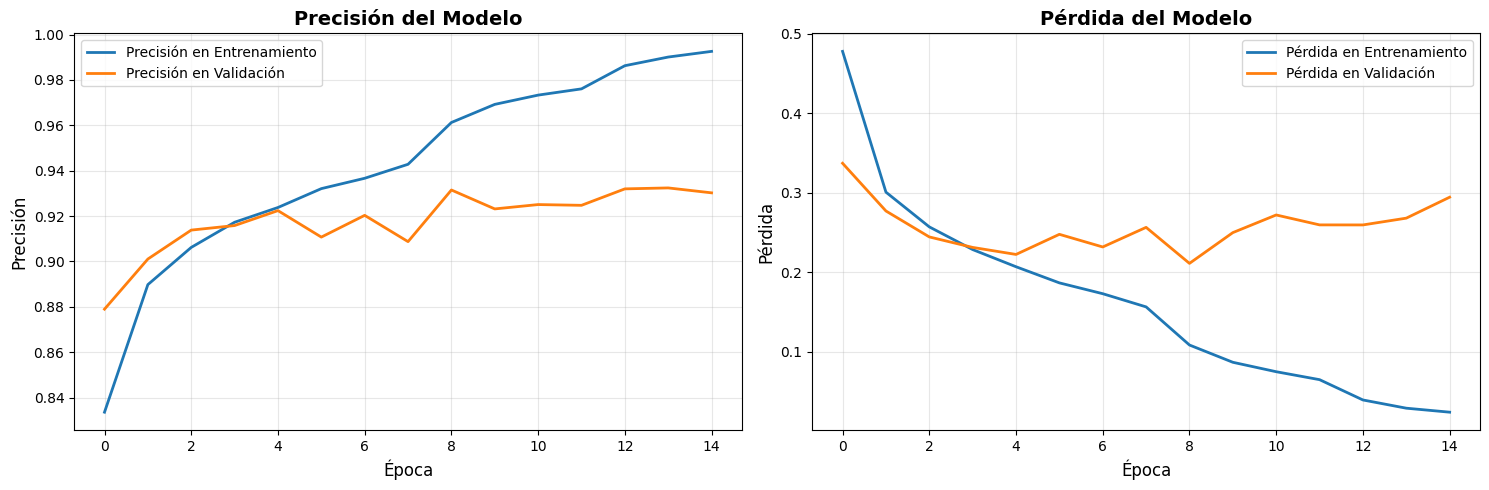

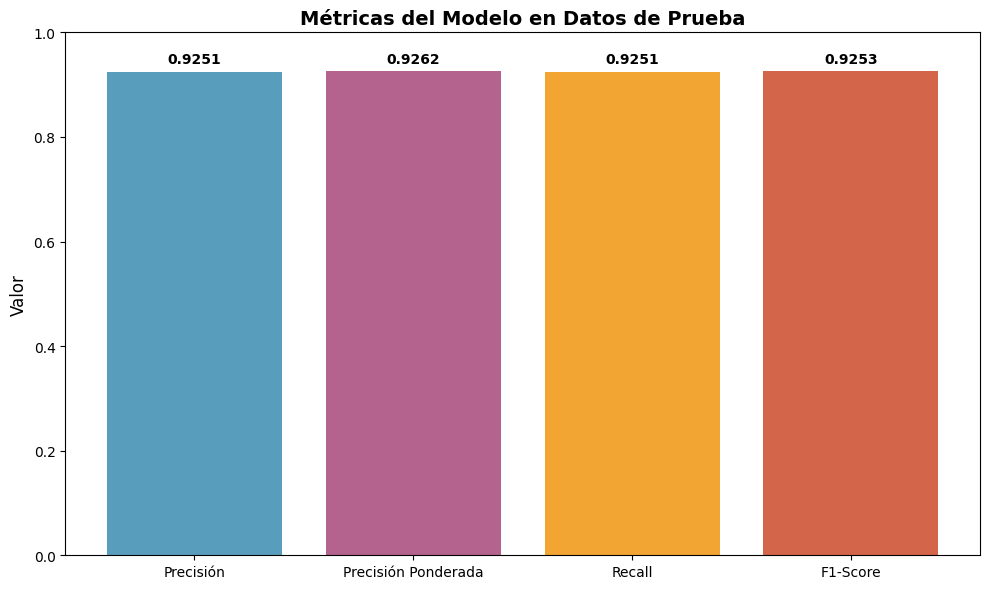


Generando matriz de confusión...


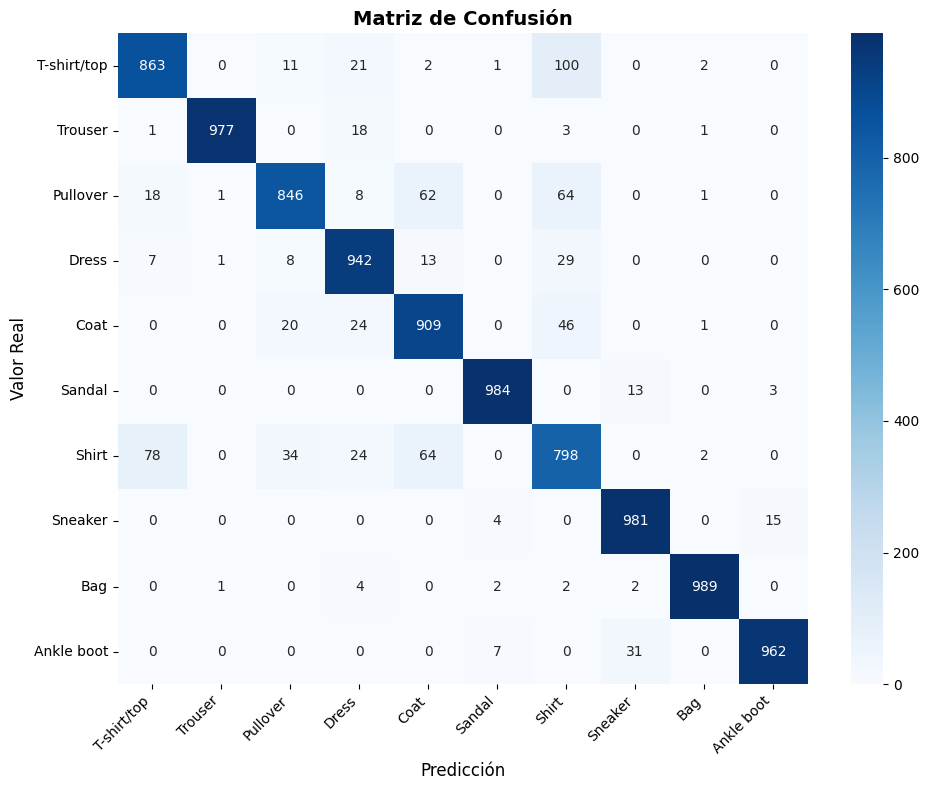


Mostrando ejemplos de predicciones...


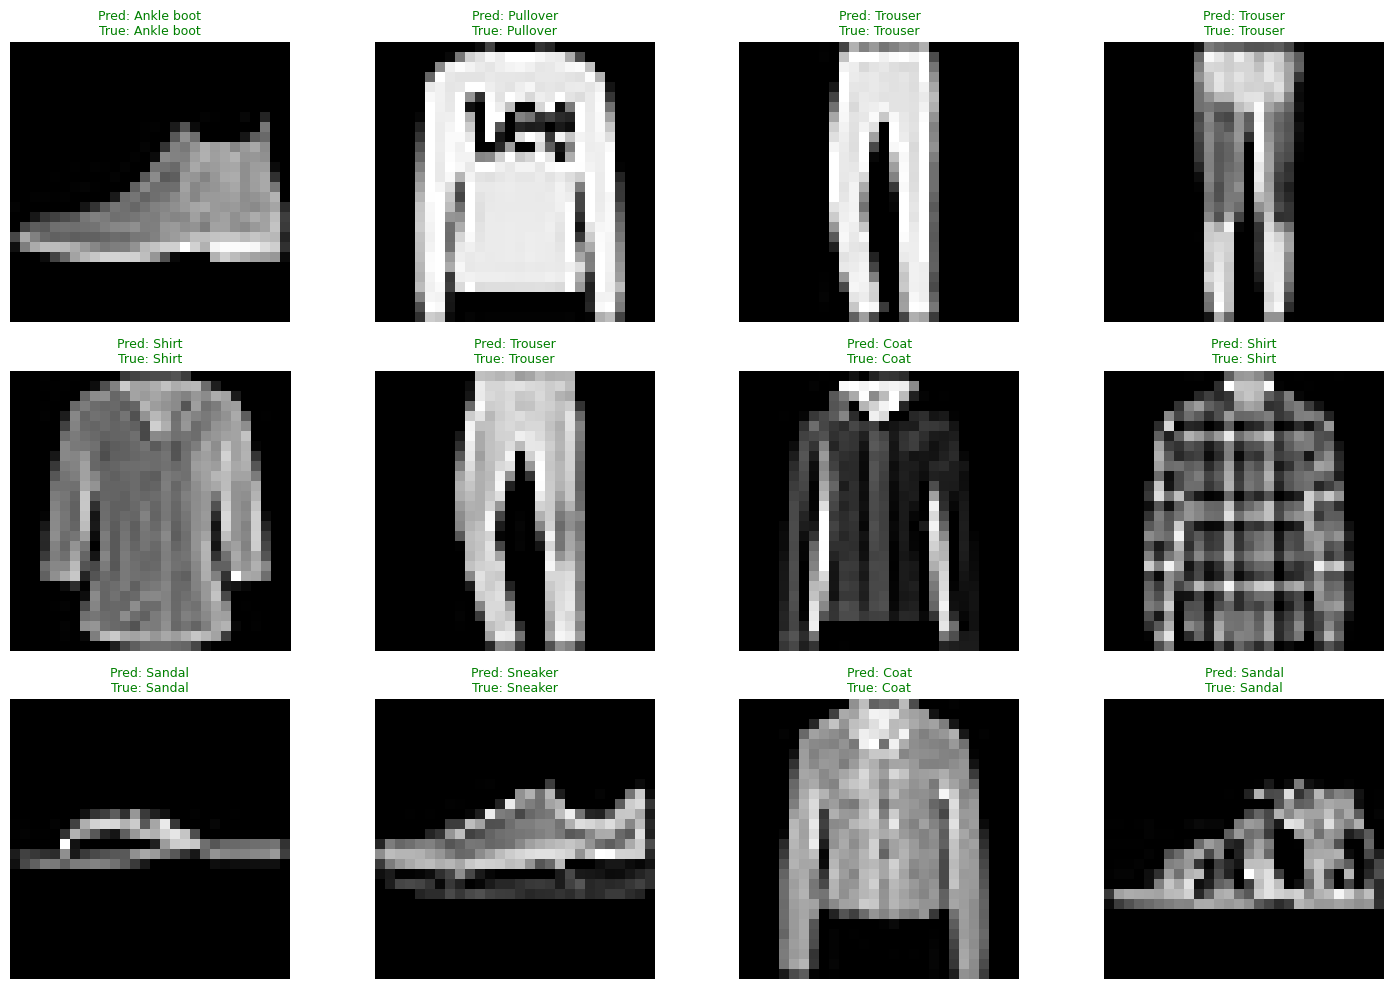


RESUMEN FINAL
Épocas entrenadas: 15
Precisión final en entrenamiento: 0.9926
Precisión final en validación: 0.9302
Precisión en prueba: 0.9251
Todas las gráficas han sido guardadas en el directorio actual


In [ ]:
# Importaciones necesarias
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'
os.environ['TF_ENABLE_CUDNN_TENSOR_OP_MATH'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '0'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.mixed_precision import set_global_policy
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import time

# Configuración de política de precisión mixta
set_global_policy('mixed_float16')

# Configuración de GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configurada correctamente")
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")

# CARGAR Y PREPROCESAR DATOS FASHION-MNIST
print("=" * 60)
print("CARGANDO Y PREPROCESANDO DATASET FASHION-MNIST")
print("=" * 60)

# Cargar dataset Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Normalizar píxeles a rango [0,1]
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Aplanar imágenes de 28x28 a vector 784x1
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Dividir los datos (80% entrenamiento, 20% validación)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_flat, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Remodelar los datos para CNN (28x28x1)
X_train_cnn = X_train_split.reshape(-1, 28, 28, 1)
X_val_cnn = X_val_split.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_flat.reshape(-1, 28, 28, 1)

print(f"Entrenamiento: {X_train_cnn.shape[0]} imágenes")
print(f"Validación: {X_val_cnn.shape[0]} imágenes")
print(f"Prueba: {X_test_cnn.shape[0]} imágenes")

# Clases de Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# MEJORES HIPERPARÁMETROS ENCONTRADOS
BEST_PARAMS = {
    'batch_size': 64,
    'epochs': 15,
    'dropout_rate': 0.5,
    'filters_layer1': 64,
    'learning_rate': 0.001
}

print("\n" + "=" * 60)
print("ENTRENANDO MODELO CON MEJORES HIPERPARÁMETROS")
print("=" * 60)
print(f"Hiperparámetros: {BEST_PARAMS}")

# Crear modelo CNN con los mejores parámetros
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(BEST_PARAMS['filters_layer1'], (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(BEST_PARAMS['dropout_rate']),
    Dense(10, activation='softmax', dtype='float32')
])

# Compilar el modelo
optimizer = Adam(learning_rate=BEST_PARAMS['learning_rate'])
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Entrenar el modelo
print("Iniciando entrenamiento...")
start_time = time.time()

history = model.fit(
    X_train_cnn, y_train_split,
    batch_size=BEST_PARAMS['batch_size'],
    epochs=BEST_PARAMS['epochs'],
    validation_data=(X_val_cnn, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

end_time = time.time()
print(f"Tiempo de entrenamiento: {(end_time - start_time) / 60:.2f} minutos")

# Evaluar el modelo
print("\nEvaluando modelo con datos de prueba...")
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")

# Hacer predicciones
y_pred_proba = model.predict(X_test_cnn, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calcular métricas adicionales
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Precisión ponderada: {precision:.4f}")
print(f"Recall ponderado: {recall:.4f}")
print(f"F1-Score ponderado: {f1:.4f}")

# Guardar el modelo
model.save('fashion_mnist_cnn_final.h5')
print("Modelo guardado como 'fashion_mnist_cnn_final.h5'")

# GRÁFICAS DE PÉRDIDA Y PRECISIÓN
print("\n" + "=" * 60)
print("GENERANDO GRÁFICAS DE ENTRENAMIENTO")
print("=" * 60)

# Crear figura con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica de precisión
ax1.plot(history.history['accuracy'], label='Precisión en Entrenamiento', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Precisión en Validación', linewidth=2)
ax1.set_title('Precisión del Modelo', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Precisión', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica de pérdida
ax2.plot(history.history['loss'], label='Pérdida en Entrenamiento', linewidth=2)
ax2.plot(history.history['val_loss'], label='Pérdida en Validación', linewidth=2)
ax2.set_title('Pérdida del Modelo', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Pérdida', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfica adicional: Comparación de métricas finales
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Precisión', 'Precisión Ponderada', 'Recall', 'F1-Score']
values = [test_accuracy, precision, recall, f1]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

bars = ax.bar(metrics, values, color=colors, alpha=0.8)
ax.set_title('Métricas del Modelo en Datos de Prueba', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor', fontsize=12)
ax.set_ylim(0, 1)

# Añadir valores en las barras
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('cnn_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfica de matriz de confusión (opcional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\nGenerando matriz de confusión...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar algunas predicciones
print("\nMostrando ejemplos de predicciones...")
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[i], cmap='gray')
    pred_label = class_names[y_pred[i]]
    true_label = class_names[y_test[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.savefig('cnn_predictions_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("RESUMEN FINAL")
print("=" * 60)
print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Precisión final en entrenamiento: {history.history['accuracy'][-1]:.4f}")
print(f"Precisión final en validación: {history.history['val_accuracy'][-1]:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Todas las gráficas han sido guardadas en el directorio actual")